# A Sinous Violin

The aim of this short notebook is to show how to use [NumPy](http://www.numpy.org/) and [SciPy](https://www.scipy.org/) to play with spectral audio signal analysis (and synthesis). 

Lots of prior knowledge is assumed, and here no *signal theory* (nor its mathematical details) will be discussed. The reader interested a more formal discussion is invited to read, for example: "[Spectral Audio Signal Processing](https://ccrma.stanford.edu/~jos/sasp/sasp.html)" by [Julius O. Smith III](https://ccrma.stanford.edu/~jos/) that is a precise and deep, yet manageable, introduction to the topic.

For the reader less inclined in formal details (heaven forbid that the others will read the following sentence) suffices it to say that any (periodic) signal can be obtained as a superposition of *sine* waves (with suitable frequencies and amplitures).

The roadmap of what we'll be doing is:

* take a real signal (a *flute* and a *violin* sample), 
* perform some *spectral analysis*,
* determine some of the *frequencies* having the strongest *amplitudes* in such spectrum,
* "reconstruct" a signal using just a few *sine* waves,
* play the orignal, and reconstructed sound.

As you'll see, beside what theory guarantees, this actually works and very few waves are enough to approximate the *timbre* of a musical instrument.

The [source notebook](https://github.com/mapio/sinuous-violin) is available on GitHub (under [GPL v3](https://www.gnu.org/licenses/gpl-3.0.en.html)), feel free to use [issues](https://github.com/mapio/sinuous-violin/issues) to point out errors, or to [fork it](https://help.github.com/articles/fork-a-repo/) to suggest edits.

A special thanks to the friend and colleague [Federico Pedersini](https://homes.di.unimi.it/pedersini/) for tolerating my endless discussion and my musings.

## The usual notebook setup

Beside the already mentioned [NumPy](http://www.numpy.org/) and [SciPy](https://www.scipy.org/), we'll use [librosa](https://github.com/librosa/librosa) to read the WAV files containing the samples, and [matplotlib](https://matplotlib.org/) because a picture is worth a thousand words; to play the samples we'll use the standard [Audio](http://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html?highlight=AUdio#IPython.display.Audio) display class of [IPython](https://ipython.org/).

In [1]:
%matplotlib inline

from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

plt.rcParams['figure.figsize'] = 8, 4
plt.style.use('ggplot')

## Let's begin

We'll fix the sampling rate once and for all, to 8000Hz that is enough for our audio purposes, yet low enough to reduce the number of samples involved in the following computations.

In [2]:
RATE = 8000

We define a couple of helper functions, to *load* the samples in a WAV file and to generate a *sine* wave of given *frequency* and *duration* (given the sampling `RATE` defined above).

In [3]:
def load_signal_wav(name):
    signal, _ = librosa.load(name + '.wav', sr = RATE, mono = True)
    return signal

In [4]:
def sine_wave(freq, duration):
    return np.sin(np.arange(0, duration, 1 / RATE) * freq * 2 * np.pi) 

Let's check we've done a good job by playing a couple of seconds of a "pure A", that is a sine wave at 440hz

In [5]:
samples_sine = sine_wave(440, 2)
Audio(samples_sine, rate = RATE)

Similarly, let's load our *flute* sample and play it

In [6]:
samples_original = load_signal_wav('violin')
Audio(samples_original, rate = RATE)

## Some analysis

Using the [specgram](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.axes.Axes.specgram.html) 
function we can plot a [spectrogram](https://ccrma.stanford.edu/~jos/mdft/Spectrograms.html)

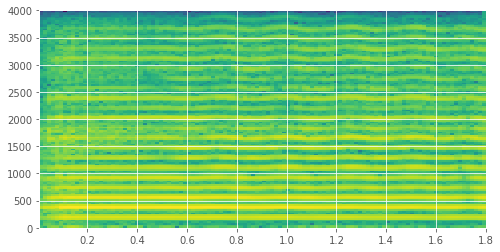

In [7]:
plt.specgram(samples_original, Fs = RATE);

even specifing just (the sampling frequency) `Fs`, that is the only required parameter, and without fiddling with all the others, we can already see *qualitatively* that there are just a few relevant frequencies (the yellow lines).

To get the precise values (and amplitudes) of such frequencies we'll need a more *quantitative* tool, namely the [scipy.fftpack.fft](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html) function that performs a [Fast Fourier Transform](https://ccrma.stanford.edu/~jos/mdft/Fast_Fourier_Transform_FFT.html), and the helper function [scipy.fftpack.fftfreq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fftfreq.html) that locates the actual frequencies used by the FFT computation.

In [8]:
N = samples_original.shape[0]
spectrum = sp.fftpack.fft(samples_original)
frequencies = sp.fftpack.fftfreq(N, 1 / RATE)

Since the signal is *real* (that is, is made of real values), we need just the first half of the returned values; moreover we are interested just in the *amplitudes* of the spectrum

In [9]:
frequencies = frequencies[:N//2]
amplitudes = np.abs(spectrum[:N//2])

Plotting the result makes it evident that, in accordance with what we observed in the spectrogram, there are just a few peaks

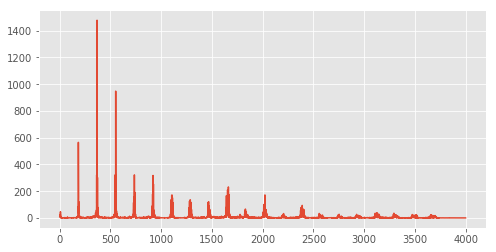

In [10]:
plt.plot(frequencies, amplitudes);

### Locating the maxima

To find the frequencies where such peaks are located turns out to be a little tricky: to locate the peaks the [scipy.signal.find_peaks_cwt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks_cwt.html) needs a `widths` parameter specifing "the expected width of peaks of interest". 

After some trial and error, one can see that `60` is a reasonable width to get *close enough* to the actual peaks. 

In [11]:
peak_indices = sp.signal.find_peaks_cwt(amplitudes, widths = (60,))

but plotting the peaks reveals that sometimes they are a bit off

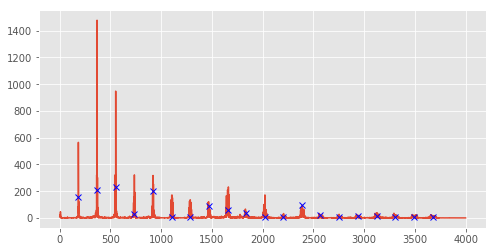

In [12]:
plt.plot(frequencies, amplitudes)
plt.plot(frequencies[peak_indices], amplitudes[peak_indices], 'bx');

let's look at `10` values around the located peaks to get the actual maxima of the amplitudes, and then use such values to locate the frequencies where they are attained

In [13]:
amplitudes_maxima = list(map(lambda idx: np.max(amplitudes[idx - 10:idx + 10]), peak_indices))
frequencies_maxima = frequencies[np.isin(amplitudes, amplitudes_maxima)]

by plotting these values we can tell we did a good job; using a logarithmic scale we can better appreciate that also the few last values correspond to actual peaks (albeit of much smaller amplitude)

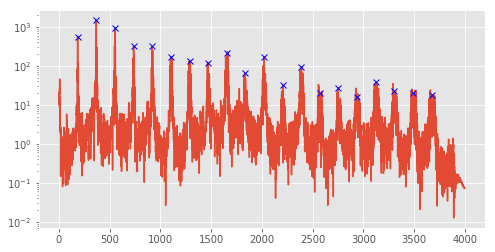

In [14]:
plt.semilogy(frequencies, amplitudes)
plt.plot(frequencies_maxima, amplitudes_maxima, 'bx');

We can isolate our peak finding function for further use

In [15]:
def find_peaks(frequencies, amplitudes, width, lookaround):
    peak_indices = sp.signal.find_peaks_cwt(amplitudes, widths = (width,))
    amplitudes_maxima = list(map(lambda idx: np.max(amplitudes[idx - lookaround:idx + lookaround]), peak_indices))
    frequencies_maxima = frequencies[np.isin(amplitudes, amplitudes_maxima)]
    return frequencies_maxima, amplitudes_maxima

## Finally the synthesis

Now that we have both the relevant frequencies and amplitudes, we can put together the sine waves and build an approximation of the original signal

In [16]:
def compose_sine_waves(frequencies, amplitudes, duration):
    return sum(map(lambda fa: sine_wave(fa[0], 2) * fa[1], zip(frequencies, amplitudes)))

In [17]:
samples_reconstructed = compose_sine_waves(frequencies_maxima, amplitudes_maxima, 2)

The spectrogram looks promising

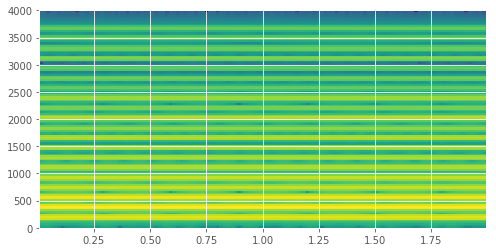

In [18]:
plt.specgram(samples_reconstructed, Fs = RATE);

but what is striking is how similar the reconstructed sound is with respect to the original one

In [19]:
Audio(samples_reconstructed, rate = RATE)

exspecially if you compare it with just the sine wave corresponding to the maximum amplitude

In [20]:
Audio(sine_wave(frequencies_maxima[np.argmax(amplitudes_maxima)], 2), rate = RATE)

## Not just violins

Of course the same game can be played with other samples, let's try a flute

In [21]:
samples_original = load_signal_wav('flute')
Audio(samples_original, rate = RATE)

We can replicate the steps to obtain the relevant frequenceis and amplitudes, plotting the result as a quick check

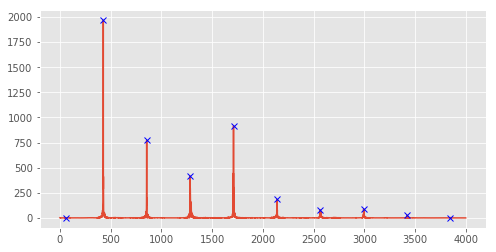

In [22]:
N = samples_original.shape[0]
frequencies = sp.fftpack.fftfreq(N, 1 / RATE)[:N//2]
amplitudes = np.abs(sp.fftpack.fft(samples_original))[:N//2]

frequencies_maxima, amplitudes_maxima = find_peaks(frequencies, amplitudes, 100, 50)
plt.plot(frequencies, amplitudes)
plt.plot(frequencies_maxima, amplitudes_maxima, 'bx');

and again, play the obtained sound, compared to the maximum amplitude sine wave

In [23]:
samples_reconstructed = compose_sine_waves(frequencies_maxima, amplitudes_maxima, 2)
Audio(samples_reconstructed, rate = RATE)

In [24]:
Audio(sine_wave(frequencies_maxima[np.argmax(amplitudes_maxima)], 2), rate = RATE)

## Wrap up

As promised, this notebook shows how:

* take a real signal, 
* perform the [Fast Fourier Transform](https://ccrma.stanford.edu/~jos/mdft/Fast_Fourier_Transform_FFT.html),
* locate the frequencies corresponding to the *peaks* of the amplitudes in such spectrum,
* use such values to build a synthetic signal.

Even if the result is exactly what one can expect from the theory, the notebook provides a couple of quite surprising examples where a few sine waves can convey the *timbre* of two very different musical instruments such as a violin and a flute.